### Imports


In [1]:
import sys
sys.executable

'/home/ad9697/anaconda3/envs/cwb/bin/python'

In [2]:
# python -m ipykernel install --user

In [5]:
import sys
sys.path.insert(0, '../Continuous-Weight-Balancing')
from weight_balancing import continuous_weight
from util import plot_cont_var

import numpy as np
import sklearn
import pandas as pd
from sklearn.metrics import roc_auc_score
from pathlib import *
from matplotlib import pyplot as plt
from scipy import stats
from math import pi

## Sklearn models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## Keras imports
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


## Bokeh plotting
from bokeh.io import output_notebook
from bokeh.io import show
from bokeh.plotting import figure
from bokeh.transform import cumsum
from bokeh.palettes import Spectral6
from bokeh.models import ColumnDataSource
from bokeh.layouts import gridplot


In [6]:
#### Constants ####

SEED = 42
N_ESTIMATORS = 200 # Random Forest

In [7]:
output_notebook()

Loading BokehJS ...

In [8]:
!which python

/home/ad9697/anaconda3/envs/cwb/bin/python


## Understand the Heart Disease data 

In [7]:
df = pd.read_csv('../data/hd/data.csv')
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


Let's have a look at what each of these columns means:

1. **age** -> Age of the person.
2. **sex** -> Sex of the person.  (1 = male; 0 = female)
3. **cp** -> Chest Pain Type. It can take values of 0, 1, 2, 3.
4. **trestbps** -> Resting Blood Presssure (Measured in mm Hg on admission to the hospital). It can take continuous values from 94 to 200.  
5. **chol** -> Serum Cholestrol in mg/dl. It also takes continuous values.
6. **fbs** -> Fasting Blood Sugar. It can take value of either 1 or 0.
7. **restecg** -> Resting Electrocardiographic Results. It can take value of 0, 1 or 2.
8. **thalach** -> Maximum Heart Rate achieved. It can take continuous value from 71 to 202.
9. **exang** -> Exercise Induced Angina. It can take value either of 0 or 1.
10. **oldpeak** -> ST depression induced by exercise relative to rest. It takes continuous decimal values.
11. **slope** -> the slope of the peak exercise ST segment. It can take value of either 0, 1 or 2.
12. **ca** -> Number of major vessels colored by flourosopy. It can take value of either 0, 1, 2, 3 or 4. 
13. **thal** -> 3 = normal; 6 = fixed defect; 7 = reversable defect
14. **target** -> Indicates the presence or absence of heart disease. (= the predicted attribute)

In [24]:
# unique, counts = np.unique(df['target'].values)
unique = ["0", '1']

top = [df['target'].value_counts()[0], df['target'].value_counts()[1]]
source = ColumnDataSource(data = dict(Target = unique, counts = top, color = Spectral6))

p = figure(
    x_range = unique,
    plot_height = 500,
    plot_width = 500,
    x_axis_label = 'Target',
    y_axis_label = 'Count(Target)',
    title = 'Count of People Having Heart Disease and Not Having Heart Disease',
    tools = "hover", tooltips="@Target: @counts"
)

p.vbar(
    x = 'Target',
    top = 'counts',
    bottom = 0,
    width = 0.9,
    source = source,
    color = 'color'
)

GlyphRenderer(id='2173', ...)

In [9]:
print("Percentage of people having Heart Disease", round(df['target'].value_counts()[1] / (df['target'].value_counts()[0] + df['target'].value_counts()[1]), 2) * 100)
print("Percentage of people not having Heart Disease", round(df['target'].value_counts()[0] / (df['target'].value_counts()[0] + df['target'].value_counts()[1]), 2) * 100)

Percentage of people having Heart Disease 54.0
Percentage of people not having Heart Disease 46.0


In [10]:
target = {
            'No Heart Disease' : df['target'].value_counts()[0], 
          'Have Heart Disease' : df['target'].value_counts()[1]
         }

data = pd.Series(target).reset_index(name = 'value').rename(columns = {'index':'target'})
data['angle'] = data['value']/data['value'].sum() * 2 * pi
data['color'] = ['skyblue', 'salmon']

In [25]:
p1 = figure(
            plot_height = 500, 
            plot_width = 500, 
            title = "Proportion of People Having Heart Disease and not Having Heart Disease", 
            toolbar_location = None,
            tools = "hover", 
            tooltips = "@target: @value", 
            x_range = (-0.5, 1.0)
            )

p1.wedge(
        x = 0, y = 1, radius = 0.4,
        start_angle = cumsum('angle', include_zero=True), 
        end_angle = cumsum('angle'),
        line_color = "white", 
        fill_color = 'color', 
        legend_field = 'target', 
        source = data
        )

p1.legend.location = "top_right"


p1.legend.label_text_font_size = '5pt'

show(gridplot([[p], [p1]]))

In [12]:
## Categorical vs Cont

categorical_var = []
continuous_var = []

for column in df.columns:
    if len(df[column].unique()) <= 10:
#         print(f"{column} : {df[column].unique()}")
        categorical_var.append(column)
#         print()
    else:
        continuous_var.append(column)
        
print("Categorical Variables are: ", categorical_var)
print("Continuous Variables are: ", continuous_var)

Categorical Variables are:  ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']
Continuous Variables are:  ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


## Use-case

We see from the plot below that the dataset is biased heavily in favor of people aged 50 and above. However, looking at the label distributions, we find peaks in the histogram (for +ve labels) below age 50. This is a bias we would ideally like to eliminate through weight balancing.

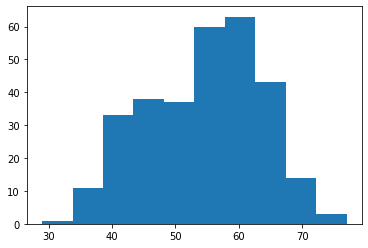

In [29]:
plt.hist(df['age'])
plt.show()

In [30]:
p16 = plot_cont_var('age')
show(p16)

In [19]:
# from matplotlib import pyplot as plt
# plt.hist(df['thalach'])
# plt.show()

In [20]:
# plt.hist(df['chol'])
# plt.show()

### Loading dataset + weight traits

We assume all data is mean-normalized beforehand. The weights for age as a trait have been saved beforehand. 

In [137]:
data_dir = Path('../data/hd')
X_train = np.load(data_dir / 'X_train.npy')
y_train = np.load(data_dir / 'y_train.npy')
X_val = np.load(data_dir / 'X_val.npy')
y_val = np.load(data_dir / 'y_val.npy')
X_test = np.load(data_dir / 'X_test.npy')
y_test = np.load(data_dir / 'y_test.npy')


traits_train = np.load(data_dir / 'traits_train.npy')
traits_val = np.load(data_dir / 'traits_val.npy')
traits_test = np.load(data_dir / 'traits_test.npy')


# Merge both val & test sets for more samples
traits_oos = np.concatenate([traits_val, traits_test], 0)
X_oos = np.concatenate([X_val, X_test], 0)
y_oos = np.concatenate([y_val, y_test], 0)

# Below 60 years of age
CUTOFF = 60
X_below = X_oos[traits_oos < CUTOFF]
y_below = y_oos[traits_oos < CUTOFF]



In [138]:
traits_train.min(), traits_val.min(), traits_test.min(), traits_train.max(), traits_val.max(), traits_test.max()

(29, 35, 34, 77, 70, 71)

### Generating weights on the fly

In [11]:
## Load a scipy.stats.rv_continuous obj
min_trait = traits_train.min()
range_trait = traits_train.max() - traits_train.min()
target = stats.uniform(loc = min_trait, scale = range_trait)

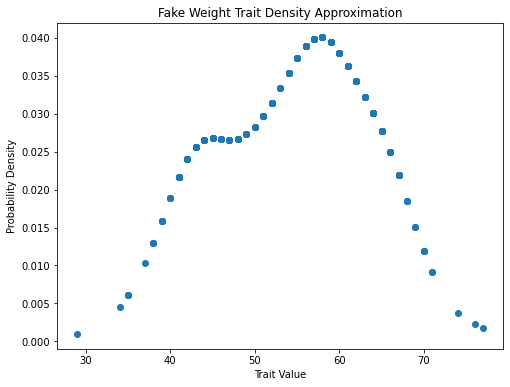

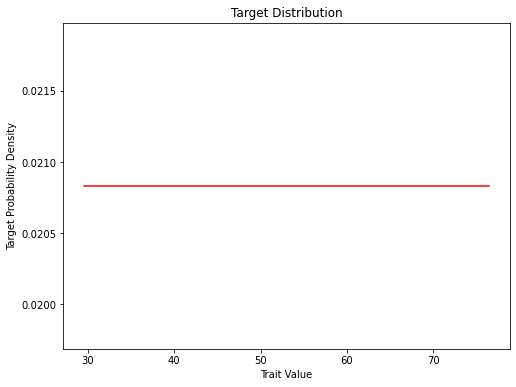

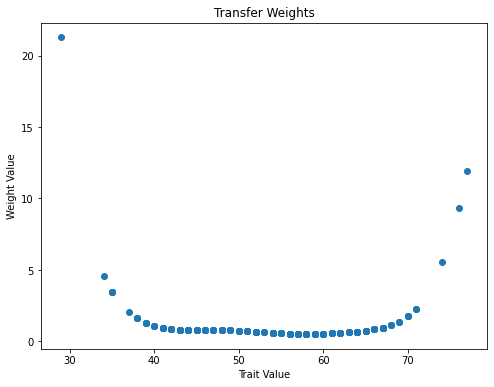

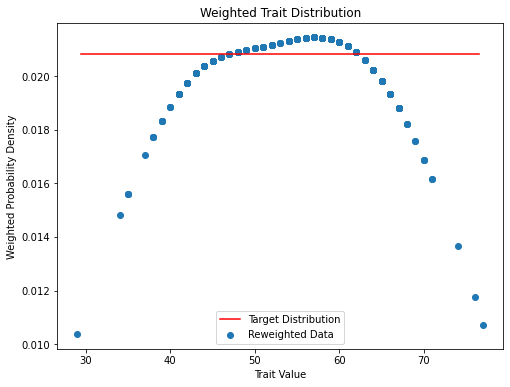

In [12]:
wts_tr = continuous_weight(traits_train, target, addl_trait = None, clipping = None, verbose = True)
# wts_val = continuous_weight(traits_val, target, addl_trait = None, clipping = None, verbose = False)


We notice weight trait (age in this example) isn't made exactly uniform, but we even out the peaks in the 40-60 age group.

# Random Forest

#### Without sample balancing on the entire out-of-sample set

In [100]:
clf_unbalanced = RandomForestClassifier(n_estimators=100, random_state=SEED)
clf_unbalanced.fit(X_train, y_train, sample_weight=None)

# # Actual class predictions
# rf_predictions = clf_unbalanced.predict(X_val)

# Probabilities for each class
rf_probs = clf_unbalanced.predict_proba(X_oos)[:, 1]

roc_value = roc_auc_score(y_oos, rf_probs)
print(roc_value)

0.9401939655172413


#### Now training using continuous sample-weights as a function of age

In [101]:
clf_balanced = RandomForestClassifier(n_estimators=200, random_state=SEED)
clf_balanced.fit(X_train, y_train, sample_weight=wts_tr)

rf_probs_bal = clf_balanced.predict_proba(X_oos)[:, 1]

roc_value_bal = roc_auc_score(y_oos, rf_probs_bal)
print(roc_value_bal)


0.943426724137931


### Evaluating on ages below 60

In [102]:
## X_below & y_below defined at start of notebook

rf_probs = clf_unbalanced.predict_proba(X_below)[:, 1]
roc_value = roc_auc_score(y_below, rf_probs)
print("Unbalanced ROC_value: ", roc_value)

rf_probs_bal = clf_balanced.predict_proba(X_below)[:, 1]
roc_value_bal = roc_auc_score(y_below, rf_probs_bal)
print("Balanced ROC_value: ", roc_value_bal)


Unbalanced ROC_value:  0.9554924242424242
Balanced ROC_value:  0.9659090909090908


**We get a boost in performance for ages < 60 because of balancing**

# Logistic Regression

#### Without sample balancing on the entire out-of-sample set


In [159]:
clf_unbalanced = LogisticRegression(random_state=SEED)
clf_unbalanced.fit(X_train, y_train, sample_weight=None)

rf_probs = clf_unbalanced.predict_proba(X_oos)[:, 1]
roc_value = roc_auc_score(y_oos, rf_probs)
print("ROC value for unbalanced data: ", roc_value)



ROC value for unbalanced data:  0.9245689655172413


#### Now training using continuous sample-weights as a function of age

In [162]:
clf_balanced = LogisticRegression(random_state=SEED)
clf_balanced.fit(X_train, y_train, sample_weight=wts_tr)

rf_probs_bal = clf_balanced.predict_proba(X_oos)[:, 1]

roc_value_bal = roc_auc_score(y_oos, rf_probs_bal)
print("ROC value for balanced data: ", roc_value_bal)


ROC value for balanced data:  0.9267241379310345


### Evaluating on ages below 60


In [163]:
## X_below & y_below defined at start of notebook

rf_probs = clf_unbalanced.predict_proba(X_below)[:, 1]
roc_value = roc_auc_score(y_below, rf_probs)
print("Unbalanced ROC_value: ", roc_value)

rf_probs_bal = clf_balanced.predict_proba(X_below)[:, 1]
roc_value_bal = roc_auc_score(y_below, rf_probs_bal)
print("Balanced ROC_value: ", roc_value_bal)


Unbalanced ROC_value:  0.9261363636363638
Balanced ROC_value:  0.9242424242424243


The balanced model does slightly worse, but the difference is *within* 0.2 %.

# 4-Layer Neural Net

In [145]:
def make_model():
    model = Sequential()
    model.add(Dense(64, input_dim=13, activation='relu'))
    model.add(Dropout(.25))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

es = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=25, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True
)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, 
                       mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
callbacks = [es, lr]

In [146]:
nn_unbalanced = make_model()
nn_unbalanced.summary()
history = nn_unbalanced.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=100, batch_size=16, verbose=1, 
                           callbacks=callbacks)



Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_160 (Dense)            (None, 64)                896       
_________________________________________________________________
dropout_45 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_161 (Dense)            (None, 16)                1040      
_________________________________________________________________
dense_162 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_163 (Dense)            (None, 1)                 9         
Total params: 2,081
Trainable params: 2,081
Non-trainable params: 0
_________________________________________________________________
Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 2s 9ms/step - los

Epoch 49/100
242/242 [==============================] - 0s 352us/step - loss: 0.2419 - accuracy: 0.9174 - val_loss: 0.3303 - val_accuracy: 0.8333
Epoch 50/100
242/242 [==============================] - 0s 346us/step - loss: 0.2470 - accuracy: 0.9132 - val_loss: 0.3307 - val_accuracy: 0.8333
Epoch 51/100
242/242 [==============================] - 0s 300us/step - loss: 0.2454 - accuracy: 0.8967 - val_loss: 0.3305 - val_accuracy: 0.8333
Epoch 52/100
242/242 [==============================] - 0s 306us/step - loss: 0.2272 - accuracy: 0.9050 - val_loss: 0.3305 - val_accuracy: 0.8333
Epoch 53/100
242/242 [==============================] - 0s 293us/step - loss: 0.2407 - accuracy: 0.9091 - val_loss: 0.3313 - val_accuracy: 0.8333

Epoch 00053: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 54/100
242/242 [==============================] - 0s 220us/step - loss: 0.2363 - accuracy: 0.9132 - val_loss: 0.3320 - val_accuracy: 0.8000
Epoch 55/100
242/242 [=====================

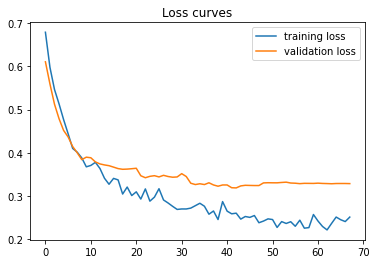

In [147]:
plt.title('Loss curves')
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()


In [148]:
rf_probs = nn_unbalanced.predict(X_oos)
roc_value = roc_auc_score(y_oos, rf_probs)
print("Unbalanced ROC_value: ", roc_value)


Unbalanced ROC_value:  0.9310344827586207


#### Now with a continuously-balanced dataset

In [149]:
nn_balanced = make_model()
history = nn_balanced.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=100, batch_size=16, verbose=1,
                         callbacks=callbacks, sample_weight=wts_tr
                         )


Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 2s 8ms/step - loss: 0.7009 - accuracy: 0.4876 - val_loss: 0.6779 - val_accuracy: 0.7000
Epoch 2/100
242/242 [==============================] - 0s 248us/step - loss: 0.6570 - accuracy: 0.6488 - val_loss: 0.6541 - val_accuracy: 0.7333
Epoch 3/100
242/242 [==============================] - 0s 316us/step - loss: 0.6372 - accuracy: 0.6777 - val_loss: 0.6086 - val_accuracy: 0.8000
Epoch 4/100
242/242 [==============================] - 0s 246us/step - loss: 0.5911 - accuracy: 0.7479 - val_loss: 0.5521 - val_accuracy: 0.8000
Epoch 5/100
242/242 [==============================] - 0s 300us/step - loss: 0.4999 - accuracy: 0.7603 - val_loss: 0.5009 - val_accuracy: 0.7667
Epoch 6/100
242/242 [==============================] - 0s 239us/step - loss: 0.4504 - accuracy: 0.7686 - val_loss: 0.4587 - val_accuracy: 0.8000
Epoch 7/100
242/242 [==============================] - 0s 270us/step - loss: 0.4065 - a

Epoch 55/100
242/242 [==============================] - 0s 336us/step - loss: 0.1930 - accuracy: 0.8884 - val_loss: 0.3328 - val_accuracy: 0.8000
Epoch 56/100
242/242 [==============================] - 0s 343us/step - loss: 0.1987 - accuracy: 0.8843 - val_loss: 0.3329 - val_accuracy: 0.8000
Epoch 57/100
242/242 [==============================] - 0s 325us/step - loss: 0.1953 - accuracy: 0.8926 - val_loss: 0.3327 - val_accuracy: 0.8000

Epoch 00057: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 58/100
242/242 [==============================] - 0s 369us/step - loss: 0.1795 - accuracy: 0.8967 - val_loss: 0.3326 - val_accuracy: 0.8000
Epoch 59/100
242/242 [==============================] - 0s 392us/step - loss: 0.1960 - accuracy: 0.8802 - val_loss: 0.3324 - val_accuracy: 0.8000
Epoch 60/100
242/242 [==============================] - 0s 308us/step - loss: 0.1843 - accuracy: 0.9091 - val_loss: 0.3325 - val_accuracy: 0.8000
Epoch 61/100
242/242 [=====================

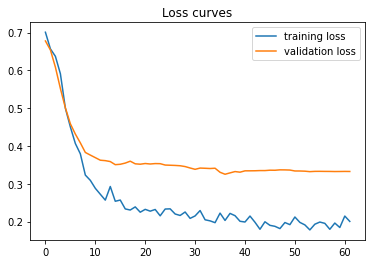

Balanced ROC_value:  0.9439655172413794


In [150]:
plt.title('Loss curves')
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()


rf_probs_bal = nn_balanced.predict(X_oos)
roc_value_bal = roc_auc_score(y_oos, rf_probs_bal)
print("Balanced ROC_value: ", roc_value_bal)


### Now evaluating *both* models on ages below 60

In [151]:
## X_below & y_below defined at start of notebook

rf_probs = nn_unbalanced.predict(X_below)
roc_value = roc_auc_score(y_below, rf_probs)
print("Unbalanced ROC_value: ", roc_value)

rf_probs_bal = nn_balanced.predict(X_below)
roc_value_bal = roc_auc_score(y_below, rf_probs_bal)
print("Balanced ROC_value: ", roc_value_bal)


Unbalanced ROC_value:  0.928030303030303
Balanced ROC_value:  0.9450757575757576


The unbalanced model's performance *decreases* for ages < 60, but the balanced model's performance **improves** for that age group.